In [1]:
import pandas as pd
import numpy as np
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.special

from bokeh.layouts import gridplot
from bokeh.plotting import figure, show, output_file, output_notebook

%matplotlib inline
pd.set_option("display.max_colwidth", 200)

In [2]:
conn = psycopg2.connect(host="localhost",database="mimic", user="postgres", password='postgres', port = '5432')
cursor = conn.cursor()

OperationalError: could not connect to server: Connection refused (0x0000274D/10061)
	Is the server running on host "localhost" (::1) and accepting
	TCP/IP connections on port 5432?
could not connect to server: Connection refused (0x0000274D/10061)
	Is the server running on host "localhost" (127.0.0.1) and accepting
	TCP/IP connections on port 5432?


In [16]:
sql = """SELECT row_id, subject_id, hadm_id, icustay_id, charttime, itemid, amount, 
       amountuom, rate, rateuom, storetime, cgid, orderid, linkorderid, 
       stopped, newbottle, originalamount, originalamountuom, originalroute, 
       originalrate, originalrateuom, originalsite
  FROM mimiciii.inputevents_cv
  where itemid in (
	'30001'  --	Packed RBC's
	,'30004'  --	Washed PRBC's
	,'30179'  --	PRBC's
    )
    and amount is not null and amount > 0 and amount < 15000
"""
df = pd.read_sql_query(sql, conn)


In [17]:
df.head()

,row_id,subject_id,hadm_id,icustay_id,charttime,itemid,amount,amountuom,rate,rateuom,...,orderid,linkorderid,stopped,newbottle,originalamount,originalamountuom,originalroute,originalrate,originalrateuom,originalsite
0,3313272,19842,121478.0,260484.0,2154-08-30 17:30:00,30001,375.0,ml,None,None,...,4611335,6084762,None,1.0,NaN,ml,Intravenous Push,NaN,None,None
1,3313273,13485,174408.0,232995.0,2143-09-27 08:30:00,30001,375.0,ml,None,None,...,8071721,8071721,None,NaN,NaN,ml,Intravenous Push,NaN,None,None
2,3313275,650,154910.0,250475.0,2109-10-18 11:45:00,30001,375.0,ml,None,None,...,3581632,3581632,None,NaN,NaN,ml,Intravenous Push,NaN,None,None
3,3313276,15411,150451.0,288783.0,2187-07-27 11:00:00,30001,375.0,ml,None,None,...,9164624,9164624,None,NaN,NaN,ml,Intravenous Push,NaN,None,None
4,3313277,22156,166025.0,228796.0,2109-09-13 11:00:00,30001,375.0,ml,None,None,...,7252710,7252710,None,NaN,NaN,ml,Intravenous Push,NaN,None,None


In [3]:
df[df['amount']<10].count() / df.count()

NameError: name 'df' is not defined

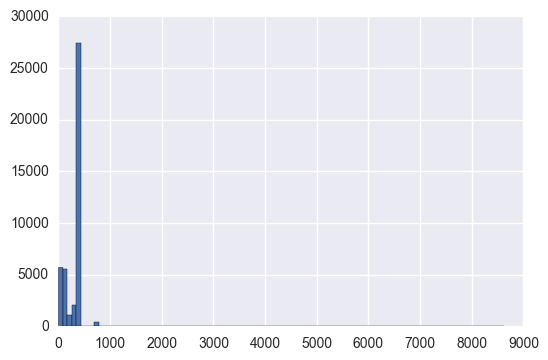

In [19]:
df.amount.hist(bins = 100)

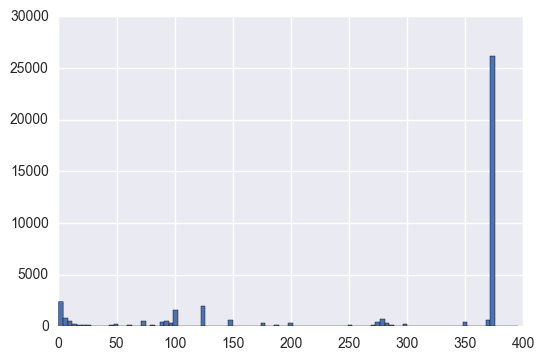

In [20]:
df[df['amount']<400].amount.hist(bins = 100)

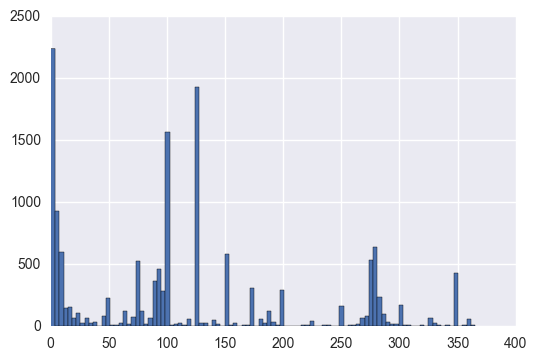

In [23]:
df[df['amount']<370].amount.hist(bins = 100)

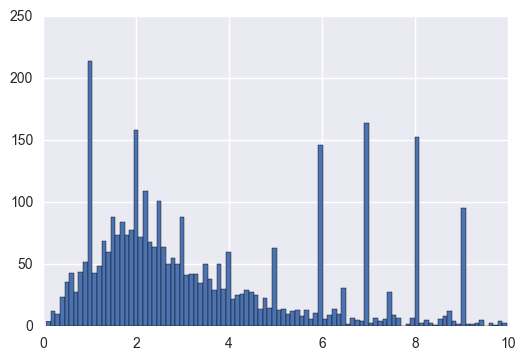

In [21]:
# should some of these be in liters??? 
df[df['amount']<10].amount.hist(bins = 100)

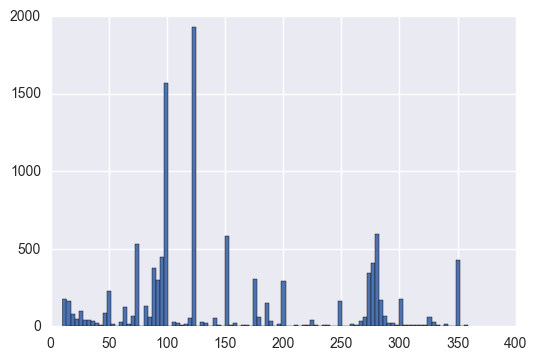

In [28]:
df[(df['amount'] > 10) & (df['amount']<360)].amount.hist(bins = 100)

In [29]:
sql = """SELECT row_id, subject_id, hadm_id, icustay_id, starttime, endtime, 
       itemid, amount, amountuom, rate, rateuom, storetime, cgid, orderid, 
       linkorderid, ordercategoryname, secondaryordercategoryname, ordercomponenttypedescription, 
       ordercategorydescription, patientweight, totalamount, totalamountuom, 
       isopenbag, continueinnextdept, cancelreason, statusdescription, 
       comments_editedby, comments_canceledby, comments_date, originalamount, 
       originalrate
  FROM mimiciii.inputevents_mv
  where itemid in (
  		'225168' --	Packed Red Blood Cells;
  		)
        and amount > 0  -- amount can be negative, often for REWRITTEN orders.  
		and cancelreason = 0 -- some orders are cancelled
		and statusdescription != 'Rewritten'  -- not sure if this should be a filter.
		and ordercategoryname not like '%Pre Admission%' -- Pre Admission fluid can be very high and cover uncertain amount of time.  
		and icustay_id is not null
        """
dfmv = pd.read_sql_query(sql, conn)

In [31]:
dfmv.head()

,row_id,subject_id,hadm_id,icustay_id,starttime,endtime,itemid,amount,amountuom,rate,...,totalamountuom,isopenbag,continueinnextdept,cancelreason,statusdescription,comments_editedby,comments_canceledby,comments_date,originalamount,originalrate
0,79,30354,120396,243526,2154-12-25 12:10:00,2154-12-25 15:55:00,225168,374.999985,ml,99.999996,...,ml,0,0,0,FinishedRunning,None,None,None,375.0,100.0000
1,482,18082,181163,267692,2156-02-25 08:30:00,2156-02-25 11:30:00,225168,374.999994,ml,124.999998,...,ml,0,0,0,FinishedRunning,None,None,None,375.0,125.0000
2,1498,26780,117266,207673,2180-02-18 00:00:00,2180-02-18 02:19:00,225168,374.999982,ml,161.870496,...,ml,0,0,0,FinishedRunning,None,None,None,375.0,161.8705
3,1503,26780,117266,207673,2180-02-17 21:31:00,2180-02-17 23:50:00,225168,375.000024,ml,161.870514,...,ml,1,0,0,FinishedRunning,None,None,None,375.0,161.8705
4,2021,31605,127805,298189,2128-03-10 16:20:00,2128-03-10 17:15:00,225168,161.132812,ml,175.781250,...,ml,0,0,0,Stopped,None,None,None,375.0,175.0000


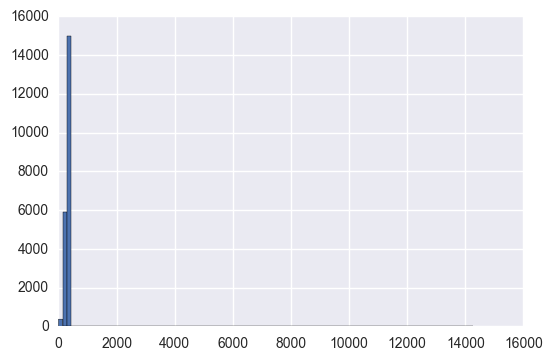

In [33]:
dfmv.amount.hist(bins = 100)

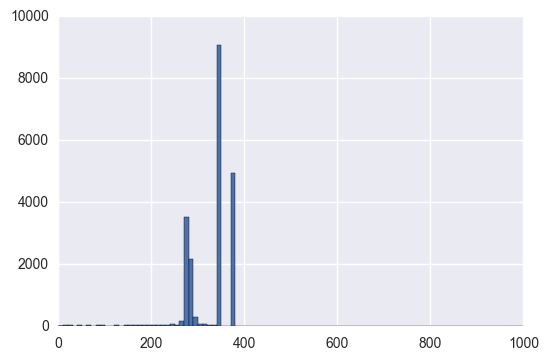

In [38]:
dfmv[dfmv['amount']<1000].amount.hist(bins = 100)

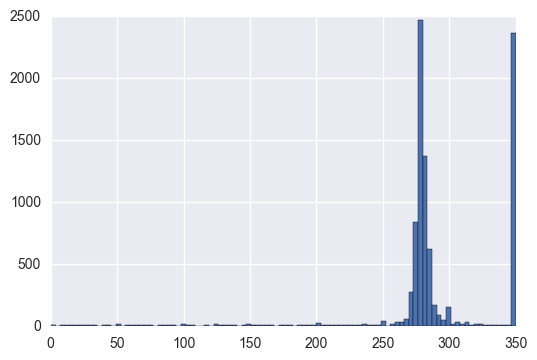

In [39]:
dfmv[dfmv['amount']<350].amount.hist(bins = 100)